<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Disease_Detection_in_Cassava_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disease Detection in Cassava Plant

**Summary**: In this lesson, we'll explore the dataset for this project. We'll be looking at images of crops in Uganda, some healthy and some with different diseases. We'll also prepare the data for later lessons.

**Objectives**:

* Check the properties of our image data
* Normalize the data set
* Check the number of data points in each class
* Balance the classes, so each has the same number of observations

**New Terms:**

* Unbalanced classes
* Undersampling

### Getting Ready

Before we start this lesson, we need to load the libraries we'll be using. These are the same ones we used in the last project.

### Exploring Our Dataset

Our data for this project is related to a [Kaggle competition](https://www.kaggle.com/competitions/cassava-leaf-disease-classification) about crops in Uganda. Here, we'll work with images of cassava plants, an extremely important staple crop. We have images of both healthy plants, and plants with one of four diseases. The goal of the competition is to create a model to diagnose what disease a plant has, or if it's healthy. This would be the first step toward speeding up this diagnosis to help farmers maintain their crops.

We'll specifically be looking at images from this [Kaggle Dataset](https://www.kaggle.com/datasets/srg9000/cassava-plant-disease-merged-20192020), which has data from the 2019 and 2020 versions of this competition.

**Task 2.2.1:** Create a variable for the `train` directory.

In [ ]:
data_dir = "data_p2"
train_dir = os.path.join(data_dir, "train")

print("Data directory:", train_dir)

#output
Data directory: data_p2/train

In the training directory, each class gets its own directory. There are five categories:

- healthy
- green mottle virus (CGM)
- bacterial blight (CBB)
- brown streak disease (CBSD)
- mosaic disease (CMD)

We'll use the directory names as our classes.

In [ ]:
classes = os.listdir(train_dir)
classes

# output
['cassava-healthy',
 'cassava-mosaic-disease-cmd',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-bacterial-blight-cbb']

**Sample Disease Image**

Let's look at a few examples of each. The function below opens four randomly selected images with the PIL library and displays them in a line.

In [ ]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

It takes two arguments:
- The directory containing the classes
- Which class we want

First, let's look at some healthy plants.

**Show healthy Cassava Images**

In [ ]:
sample_images(train_dir, "cassava-healthy")

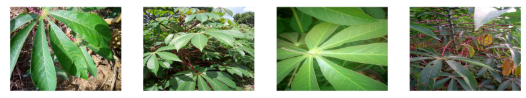

Now we can look at the four disease classes. Instead of writing out the class name by hand, you can use the `classes` variable that has all of them in it.

In [ ]:
classes

# output
['cassava-healthy',
 'cassava-mosaic-disease-cmd',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-bacterial-blight-cbb']

**Show the First Disease**

**Task 2.2.2:** Use the `sample_images` function to look at examples of the first disease class (green mottle virus).

In [ ]:
class_name = classes[0]
print(class_name)
sample_images(train_dir, class_name)

cassava-healthy

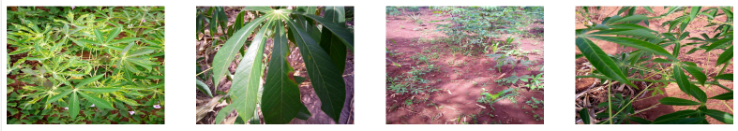

**Show Images of the Second Class**

**Task 2.2.3:** Use the `sample_images` function to look at examples of the second disease class (bacterial blight).

In [ ]:
class_name = classes[1]
print(class_name)

sample_images(train_dir, class_name)

cassava-mosaic-disease-cmd

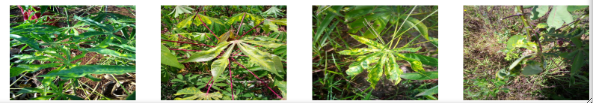

If you're using the classes variable, be careful about order. We want to skip over the healthy plants, since we've already seen them.

**Show Images of the Third Disease**

**Task 2.2.4:** Use the `sample_images` function to look at examples of the third disease class (brown streak disease).

In [ ]:
class_name = classes[2]
print(class_name)

sample_images(train_dir, class_name)

cassava-brown-streak-disease-cbsd

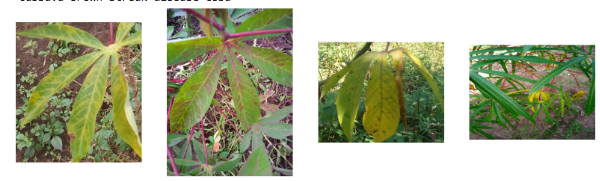

# Preparing Our Data

Now that we've seen the images we're working with, we need to get them ready for PyTorch. We'll use the same tools as the last project to load in the data.

We'll create transformations that:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$, but other sizes would work as well)
- Convert the image to a Tensor of pixel values

**Convert Image to RGB**

In [ ]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

**Transform Image to Tensor**

In [ ]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


We'll want to apply these transformations as we load in the data. We'll also want to break our dataset into batches. We can use ImageFolder and DataLoader in the same way we did in the last projec

**Create datasets and DataLoaders**

**Task 2.2.6:** Use `ImageFolder` to create a dataset applying the `transform_basic`, and `DataLoader` to create a data loader. Use a batch size of $32$.

In [ ]:
batch_size = 32
dataset = datasets.ImageFolder(root=train_dir, transform=transform_basic)
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

# output
Getting batches of shape: torch.Size([32, 3, 224, 224])


### Normalized Data

In the last project, we saw that normalized data made our network perform better. That is data with a mean of $0$ and a standard deviation of $1$. We'll want to normalize this data as well.

This is the function we used in the last project to compute the mean and standard deviation of our images.

In [ ]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

**Channel Mean and Standard Deviation**

**Task 2.2.7:** Run the `get_mean_std` function on the `dataset_loader`, and save the means and standard deviations to variables `mean` and `std`. There should be a value for each color channel, giving us vectors of length $3$.

In [ ]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

# output
Mean: tensor([0.4326, 0.4952, 0.3120])
Standard deviation: tensor([0.2179, 0.2214, 0.2091])

As expected, the means aren't $0$ and the standard deviations aren't $1$. We'll again change our transformations to include a `Normalize`. As in the last project, we need to give it a mean and standard deviation for each color channel. This is what we computed with our function.

Normalize Data loader

In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

We'll need to recreate this dataset using the new transformations.

**Task 2.2.8:** Make a new normalized dataset using `ImageFolder` and a new `DataLoader`. Be sure to use a the same batch size of $32$.

In [ ]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size)

batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

# output
Getting batches of shape: torch.Size([32, 3, 224, 224])


After the new normalize transformation, the data should have mean $0$ and standard deviation $1$ in each color channel. Let's check that.

**Verify Normalization**

**Task 2.2.9:** Use the `get_mean_std` function to verify the mean and standard deviation are correct in the `norm_loader` data.

In [ ]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

#output
Mean: tensor([ 7.6939e-05, -1.5134e-05,  2.9928e-05])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])

That has mean zero, to within rounding error, and standard deviation $1$. We're ready to move on.

### Train-Validation Split

The next thing we'll need to do is create a training dataset and a validation dataset. We can use the `random_split` tool as we did in the last project.

**Task 2.2.10:** Use `random_split` to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Be sure to use `norm_dataset`.

In [ ]:
train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

# output
Train data is 80.0% of full data
Validation data is 20.0% of full data

As in the previous project, we want to make sure the training data and validation data are similar. We'll want to double check that the two sets have similar proportions of each class.

In the previous project, we used a `class_counts` function to count how many observations were in each class. This function is now in the `training.py` file, so we can import it from there. The function takes a dataset (not a data loader) and returns a `pandas` Series of the counts of each class.

**Validation Bar Chart**

In [ ]:
from training import class_counts

And we can run it to get the number of images in each class in the training set.

In [ ]:
train_counts = class_counts(train_dataset)
train_counts

# output
cassava-bacterial-blight-cbb         1211
cassava-brown-streak-disease-cbsd    2888
cassava-green-mottle-cgm             2505
cassava-healthy                      2292
cassava-mosaic-disease-cmd           3027
dtype: int64

And we can use `pandas` to make a bar chart.

In [ ]:
train_counts.plot(kind="bar");

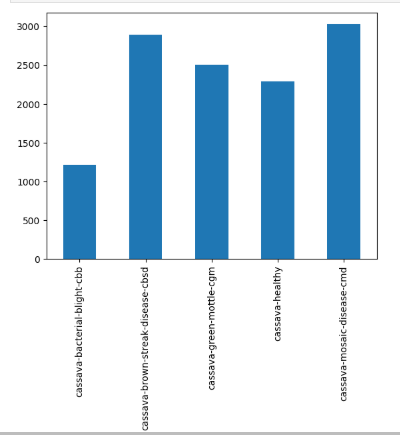

To be able to compare, we'll need to make the same plot for the validation data.

New Section

**Task 2.2.11:** Use `class_counts` to make a `pandas` Series from the validation data, and create the bar chart from it.

In [ ]:
val_counts = class_count(val_dataset)

print(val_counts)

# Create a bar chart from val_counts
val_counts.plot(kind="bar");

#output
cassava-bacterial-blight-cbb         308
cassava-brown-streak-disease-cbsd    691
cassava-green-mottle-cgm             620
cassava-healthy                      601
cassava-mosaic-disease-cmd           760
dtype: int64

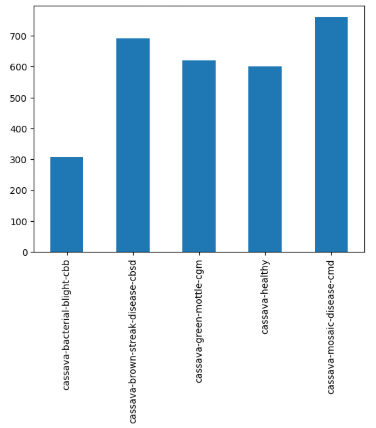

### Unbalanced Classes


Unless you got really unlucky, the two graphs should be very similar.

But the different classes have different numbers of images. There are fewer bacterial blight images, and more brown streak disease and mosaic disease images. This can cause our model to be biased — it will be less likely to call an image bacterial blight. But that doesn't reflect the world, just our training set!

This is an example of _unbalanced classes_. We can correct this by adjusting our dataset. We can either get more images until they're about the same, or remove images from the ones with more.

Since we can't get more images, we'll remove some from the larger classes. This is called _undersampling_. The function below will do this for us.

**Remove Images from the ones that is more**

In [ ]:
def undersample_dataset(dataset_dir, output_dir, target_count=None):
    """
    Undersample the dataset to have a uniform distribution across classes.

    Parameters:
    - dataset_dir: Path to the directory containing the class folders.
    - output_dir: Path to the directory where the undersampled dataset will be stored.
    - target_count: Number of instances to keep in each class. If None, the class with the least instances will set the target.
    """
    # Mapping each class to its files
    classes_files = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            classes_files[class_name] = files

    # Determine the minimum class size if target_count is not set
    if target_count is None:
        target_count = min(len(files) for files in classes_files.values())

    # Creating the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Perform undersampling
    for class_name, files in classes_files.items():
        print("Copying images for class", class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        # Randomly select target_count images
        selected_files = random.sample(files, min(len(files), target_count))

        # Copy selected files to the output directory
        for file_name in tqdm(selected_files):
            src_path = os.path.join(dataset_dir, class_name, file_name)
            dst_path = os.path.join(class_output_dir, file_name)
            copy2(src_path, dst_path)

    print(f"Undersampling completed. Each class has up to {target_count} instances.")

The function works directly with the image files. We tell it what directory contains our data, and where to put the new dataset. We'll create a new directory `data_p2/data_undersampled/train` and write files there.

**Task 2.2.12:** Create a variable `output_dir` for the new directory `data_p2/data_undersampled/train`.

**Create a New Images Folder**

In [ ]:
output_dir = os.path.join("data_p2/data_undersampled", "train")
print("Output directory:", output_dir)

# output
Output directory: data_p2/data_undersampled/train


We'll erase that directory if it already exists, and run our function to create a new, balanced dataset.

In [ ]:
! rm -rf {output_dir}

**Call the function to push images to the new folder**

In [ ]:
undersample_dataset(train_dir, output_dir)


It's expected that all classes should have the same number of images now. Let's check that by running our count. We'll need to create a new dataset first, using the new data.

**Make A Dataset of the New Undersampled Images**

**Task 2.2.13:** Create a dataset with `ImageFolder` using the data in the `output_dir`. Transform the data with the `transform_norm`.

In [ ]:
undersampled_dataset = datasets.ImageFolder(root=output_dir, transform=transform_norm)

This data should have the same classes as before.

**Show the classes**

In [ ]:
undersampled_dataset.classes

# output
['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

And all the classes should now have the same number of counts. If we recreate the bar plot, every bar should be the same height. We'll also print out the counts to make sure they're _exactly_ the same.

**Create a barchart from the undersampled data**

**Task 2.2.14:** Use `class_counts` to make a `pandas` Series from the undersampled data, and create the bar chart from it.

In [ ]:
# Important, don't change this
fig, ax = plt.subplots(figsize=(10, 6))

under_counts = class_counts(undersampled_dataset)
print(under_counts)

# Create a bar chart from under_counts
# important, you must leave `ax=ax`
under_counts.plot(kind="bar", ax=ax)

# output
cassava-bacterial-blight-cbb         1523
cassava-brown-streak-disease-cbsd    1523
cassava-green-mottle-cgm             1523
cassava-healthy                      1523
cassava-mosaic-disease-cmd           1523
dtype: int64

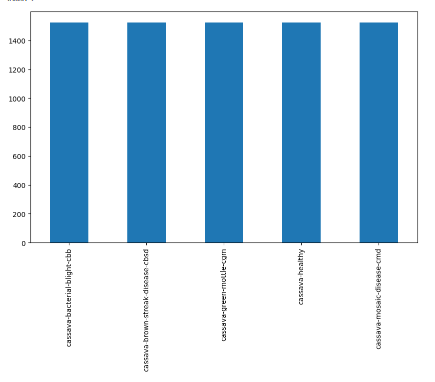

As we hoped, every class has the same number of images. We'll use this data in later lessons to train our models.

### Conclusion

Good work! We now have data that is normalized and has balanced classes. This will help our models perform better, and make them less likely to favor one class over another. Here are the key ideas we encountered:

- Our data needs to be loaded and processed
- We can normalize our data to help our models
- If we have unbalanced classes, our model might favor one class over another
- We can correct this by undersampling, throwing away data in the larger classes
